## Dataset and Problem Introduction

In this analysis, we explore [Data Science Stack Exchange](https://datascience.stackexchange.com) to determine popular topics being discussed on the exchange.

Data Source: 
- https://data.stackexchange.com/datascience/query/edit/1333306
- https://data.stackexchange.com/datascience/query/edit/1333307

Reference: https://dataquest.io/

## Loading the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

df = pd.read_csv("datasets/2019_questions.csv", parse_dates=["CreationDate"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             8839 non-null   int64         
 1   CreationDate   8839 non-null   datetime64[ns]
 2   Score          8839 non-null   int64         
 3   ViewCount      8839 non-null   int64         
 4   Tags           8839 non-null   object        
 5   AnswerCount    8839 non-null   int64         
 6   FavoriteCount  1407 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


## Cleaning the Data
- The column FavoriteCount has a large number of null values, with only 1407 out of 8839 total having a value. 
- The Tags column is listed as an object, but since there are multiple tags listed in this column, each being a string, we create a list for each question of the tags.

In [2]:
df.fillna(value={"FavoriteCount":0}, inplace=True)
df['FavoriteCount'] = df['FavoriteCount'].astype(int)
df['Tags'] = df['Tags'].str.replace("^<|>$", "").str.split("><")

## Top Used Tags

In [3]:
tag_count = dict()

for tags in df["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

tag_count = pd.DataFrame.from_dict(tag_count, orient='index')
tag_count.rename(columns={0:"Tag_Count"},inplace=True)
tag_count.sort_values(by="Tag_Count",ascending=False, inplace=True)
top_ten_tags = tag_count.head(10)

most_used = tag_count.sort_values(by="Tag_Count").tail(20)

top_ten_tags

,Tag_Count
machine-learning,2693
python,1814
deep-learning,1220
neural-network,1055
keras,935
classification,685
tensorflow,584
scikit-learn,540
nlp,493
cnn,489


* Machine-learning is the most tagged subject by a great margin, having more than 1000 tags than all but one other tag.
* Python is second, followed by Deep-Learning and Neural-Networks.

Text(0.5, 1.0, 'Top Ten Tags on Questions in Stack Exchange (2019)')

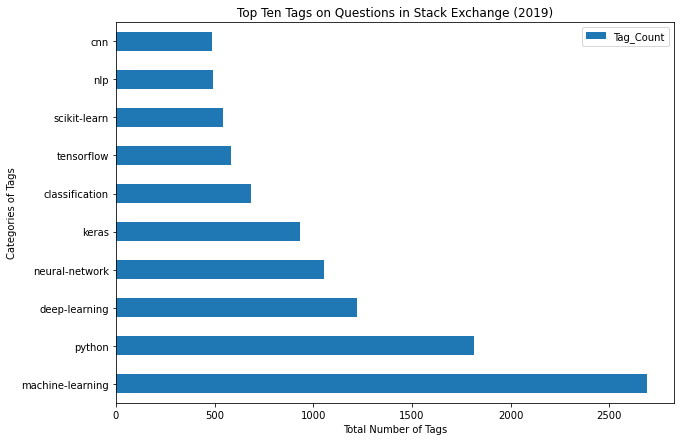

In [4]:
top_ten_tags.plot(kind='barh', figsize=(10,7))
plt.xlabel("Total Number of Tags")
plt.ylabel("Categories of Tags")
plt.title("Top Ten Tags on Questions in Stack Exchange (2019)")

## Top Views

In [5]:
view_count = dict()

for index, row in df.iterrows():
    for tag in row["Tags"]:
        if tag in view_count:
            view_count[tag] += row["ViewCount"]
        else:
            view_count[tag] = row["ViewCount"]

view_count = pd.DataFrame.from_dict(view_count, orient="index")

view_count.rename(columns={0: "View_Count"}, inplace=True)
view_count.sort_values(by="View_Count", ascending=False, inplace=True)
top_ten_views = view_count.head(10)

top_ten_views

,View_Count
python,537585
machine-learning,388499
keras,268608
deep-learning,233628
pandas,201787
neural-network,185367
scikit-learn,128110
tensorflow,121369
classification,104457
dataframe,89352


* Python is the most viewed category, even though it was the second highest tagged, and it switched places with machine learning.
* Deep Learning and Neural Networks are both behind Keras in total views, despite being both tagged more often. Pandas also has more views than Neural Networks.

Text(0.5, 1.0, 'Top Ten Most Viewed Subjects in Stack Exchange Questions (2019)')

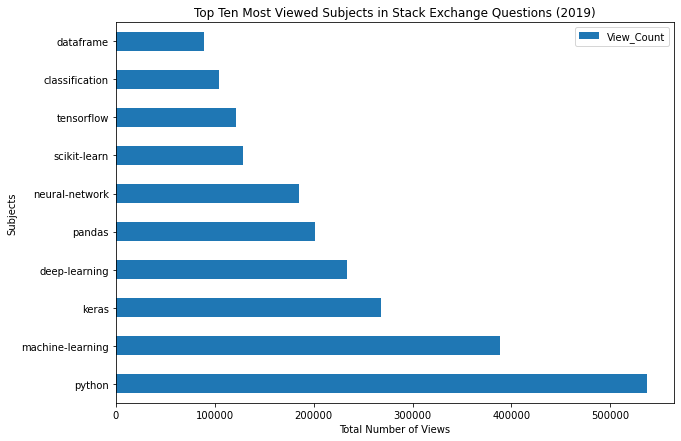

In [6]:
top_ten_views.plot(kind="barh", figsize=(10,7))
plt.xlabel('Total Number of Views')
plt.ylabel("Subjects")
plt.title("Top Ten Most Viewed Subjects in Stack Exchange Questions (2019)")

array([<AxesSubplot:title={'center':'View_Count'}>], dtype=object)

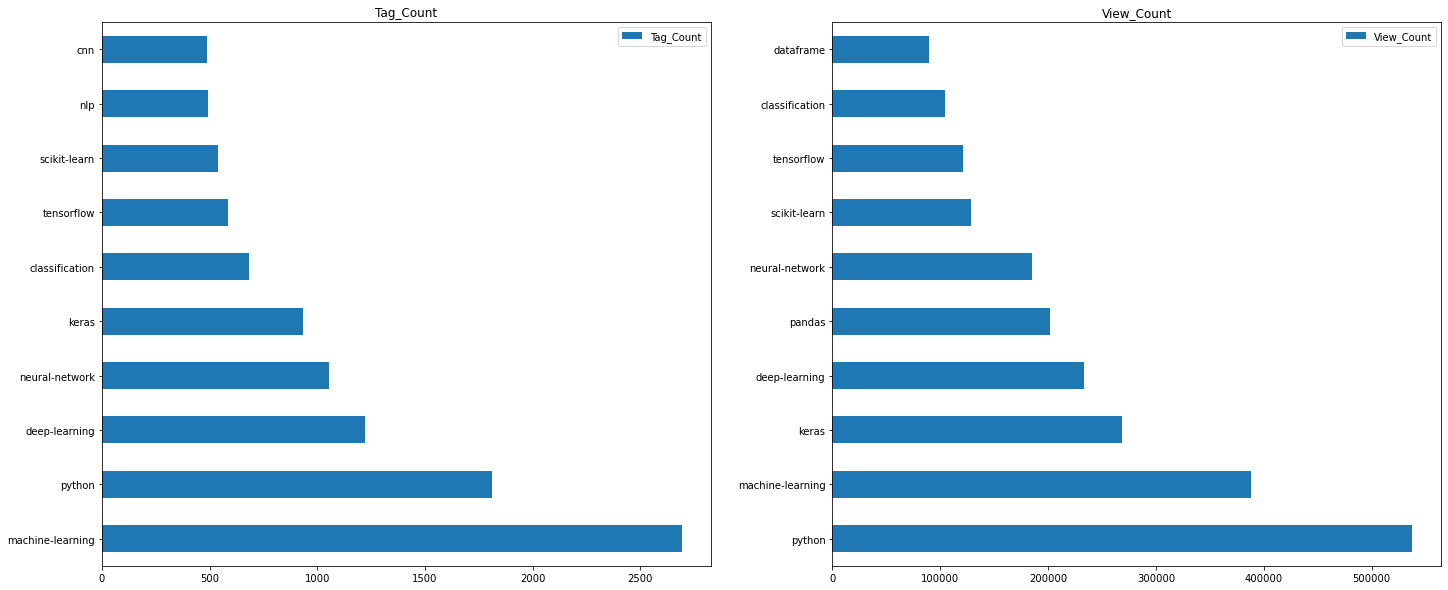

In [7]:
fig,axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches((24, 10))
top_ten_tags.plot(kind="barh", ax=axes[0], subplots=True)

top_ten_views.plot(kind="barh", ax=axes[1], subplots=True)

By viewing the two graphs together, we can see a pretty clear relationship between subjects that get tagged more often in questions and those that get more views. This makes sense, as a higher volume of tags to questions makes it more likely that a subject will be viewed. It is interesting, however, that Machine Learning is tagged in over 800 more questions than Python, but questions with Python were viewed 15,000 more times.

## Relations Between Tags

In [8]:
all_tags = list(tag_count.index)

We now create a dataframe where each row and column represents a tag.

<table class="dataframe" border="1">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>tag1</th>
      <th>tag2</th>
      <th>tag3</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>tag1</th>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>tag2</th>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>tag3</th>
      <td></td>
      <td></td>
      <td></td>
    </tr>
  </tbody>
</table>

In [9]:
associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.iloc[0:4,0:4]

,machine-learning,python,deep-learning,neural-network
machine-learning,NaN,NaN,NaN,NaN
python,NaN,NaN,NaN,NaN
deep-learning,NaN,NaN,NaN,NaN
neural-network,NaN,NaN,NaN,NaN


We now fill this dataframe with zeroes and then, for each lists of tags in `df["Tags"]`, we increment the intervening tags by one. The end result will be a dataframe that for each pair of tags, tells us how many times they were used together.

In [10]:
associations.fillna(0, inplace=True)

for tags in df["Tags"]:
    associations.loc[tags, tags] += 1

This dataframe is quite large, so we focus on the most used tags and add some colours to make it easier to talk about the dataframe.

In [11]:
relations_most_used = associations.loc[most_used.index, most_used.index]

def style_cells(x):
    helper_df = pd.DataFrame('', index=x.index, columns=x.columns)
    helper_df.loc["time-series", "r"] = "background-color: yellow"
    helper_df.loc["r", "time-series"] = "background-color: yellow"
    for k in range(helper_df.shape[0]):
        helper_df.iloc[k,k] = "color: blue"
    
    return helper_df

relations_most_used.style.apply(style_cells, axis=None)

,machine-learning-model,statistics,clustering,predictive-modeling,r,dataset,regression,pandas,lstm,time-series,cnn,nlp,scikit-learn,tensorflow,classification,keras,neural-network,deep-learning,python,machine-learning
machine-learning-model,224,3,3,21,7,12,8,4,5,7,4,4,18,9,21,17,10,19,37,139
statistics,3,234,3,16,16,17,16,3,1,22,1,3,6,0,19,3,11,12,35,89
clustering,3,3,257,0,16,5,2,5,3,20,0,9,24,0,12,0,8,2,45,61
predictive-modeling,21,16,0,265,13,7,28,4,13,31,6,1,12,6,27,11,13,32,35,123
r,7,16,16,13,268,6,10,2,3,22,2,4,1,1,10,10,9,5,24,63
dataset,12,17,5,7,6,340,6,14,7,6,11,11,9,9,28,13,20,32,53,99
regression,8,16,2,28,10,6,347,6,11,24,6,2,37,9,34,31,42,21,59,119
pandas,4,3,5,4,2,14,6,354,7,19,1,3,37,3,3,3,1,1,244,62
lstm,5,1,3,13,3,7,11,7,402,87,24,19,2,43,20,133,69,103,61,71
time-series,7,22,20,31,22,6,24,19,87,466,8,0,12,9,25,51,33,44,105,131


The cells highlighted in yellow tell us that `time-series` was used together with `r` 22 times. The values in blue tell us how many times each of the tags was used. We saw earlier that `machine-learning` was used 2693 times and we confirm it in this dataframe.

<AxesSubplot:>

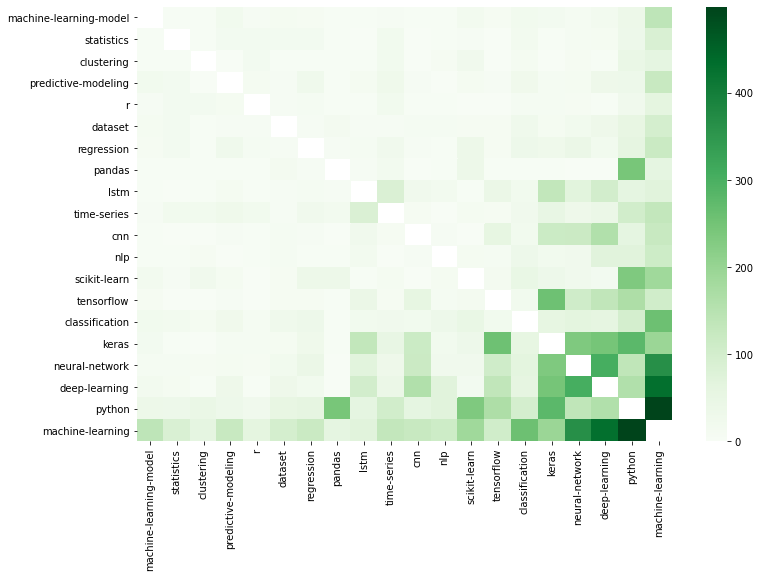

In [12]:
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = np.NaN
    
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Greens", annot=False)

The most used tags seem to have the strongest relationships, as given by the dark concentration in the bottom right corner. However, this could simply be because each of these tags is used a lot, and so end up being used together a lot without possibly even having any strong relation between them.

# Deep Learning Fad

We also find that subjects such as Neural Networks and Deep Learning are both tagged frequently, just like Machine Learning. It turns out that all of these subjects are related, which could account for the higher total tags for Machine Learning. It is likely that every time one of Neural Networks or Deep Learning is tagged, Machine Learning is also tagged as well.

Similarly, [Keras](https://keras.io/) is related to both Python, Neural Networks, and Deep Learning, meaning that they are all likely to be tagged together frequently. Since topics with Python tags are viewed frequently, Keras is also likely tagged to many of these questions, resulting in a higher value for its views in relation to its position in tags.

What we discern is that the subjects of Neural Networks and Deep Learning seem to be very popular at the moment.

So now we want to examine whether Deep Learning is here to stay, or is just a popular fad that will eventually go.

In [13]:
all_q = pd.read_csv('datasets/all_questions.csv',parse_dates=["CreationDate"])

#As before, we clean up the Tags column to be able to discern the individual tags.
all_q['Tags'] = all_q['Tags'].str.replace("^<|>$", "").str.split("><")

all_q.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"
3,45426,2019-02-12 04:51:49,[keras]
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode..."


We now filter our tags to just the ones involving Deep Learning. This consists of ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"].

To do this, we create a split in the tags and create a new column in our dataframe.

In [14]:
dl_set = ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]
def deep_learning(tags):
    for tag in tags:
        if tag in dl_set:
            return 1
        else:
            return 0

all_q["Deep_Learning"] = all_q["Tags"].apply(deep_learning)
all_q.head()

,Id,CreationDate,Tags,Deep_Learning
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",0
1,45418,2019-02-12 00:50:39,[neural-network],1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0
3,45426,2019-02-12 04:51:49,[keras],1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0


Next, we divide the information based on the quarter of each year, beginning end of 2019 and working backwards in time. 

In [15]:
all_q = all_q[all_q["CreationDate"].dt.year < 2020]

def quarter(time):
    year = str(time.year)
    quarter = str(((time.month-1))//3+1)
    return year+"Q"+quarter

all_q["Quarter"] = all_q["CreationDate"].apply(quarter)
all_q.head()

,Id,CreationDate,Tags,Deep_Learning,Quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",0,2019Q1
1,45418,2019-02-12 00:50:39,[neural-network],1,2019Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,2019Q1
3,45426,2019-02-12 04:51:49,[keras],1,2019Q1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0,2019Q1


## Popularity of Deep Learning

In [16]:
questions_per_quarter = all_q.groupby("Quarter").agg({"Deep_Learning":['sum','size']})
questions_per_quarter.head()

Deep_Learning     
                  sum size
Quarter                   
2014Q2              3  157
2014Q3              4  189
2014Q4              4  216
2015Q1              5  190
2015Q2              6  284

In [17]:
questions_per_quarter.columns = ['DL_Questions', 'Total_Questions']
questions_per_quarter.head()

,DL_Questions,Total_Questions
Quarter,,
2014Q2,3,157
2014Q3,4,189
2014Q4,4,216
2015Q1,5,190
2015Q2,6,284


In [18]:
questions_per_quarter['DL_percentage'] = questions_per_quarter['DL_Questions']/questions_per_quarter["Total_Questions"]
questions_per_quarter.head(10)

,DL_Questions,Total_Questions,DL_percentage
Quarter,,,
2014Q2,3,157,0.019108
2014Q3,4,189,0.021164
2014Q4,4,216,0.018519
2015Q1,5,190,0.026316
2015Q2,6,284,0.021127
2015Q3,13,311,0.041801
2015Q4,19,382,0.049738
2016Q1,38,516,0.073643
2016Q2,45,518,0.086873


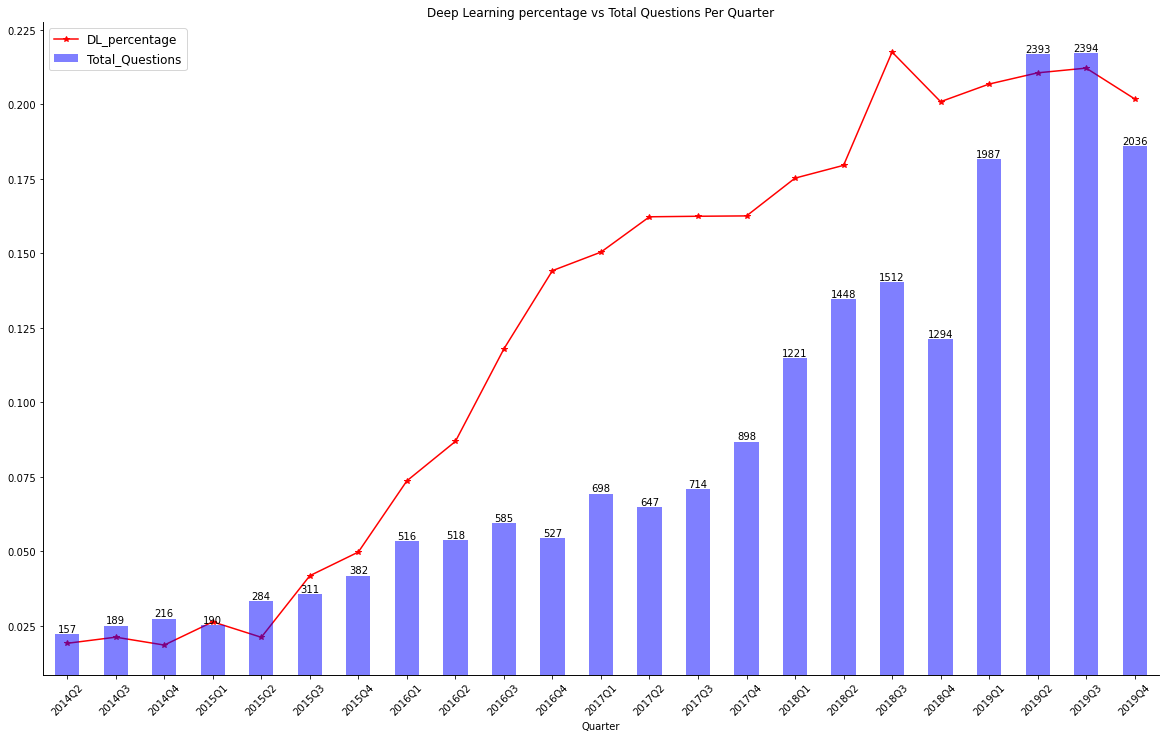

In [19]:
questions_per_quarter.reset_index(inplace=True)

ax1 = questions_per_quarter.plot(x="Quarter",y="DL_percentage",kind="line", linestyle = "-", marker = "*", color = "red", figsize=(20,12))
ax2 = questions_per_quarter.plot(x="Quarter",y="Total_Questions", kind="bar",ax=ax1, secondary_y=True,alpha=0.5, rot=45, color="blue")

for idx, t in questions_per_quarter["Total_Questions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})

for ax in (ax1,ax2):
    for loc in ("top", "right"):
        ax.spines[loc].set_visible(False)
        ax.tick_params(right=False, labelright = False)

plt.title("Deep Learning percentage vs Total Questions Per Quarter")



plt.show()

## Conclusion

The graph above shows a clear rise in popularity starting in the middle of 2015, with the percentages of questions asked rising steadily all the way through the middle of 2018, where it stayed roughly around 21% of all questions asked.

This increase in popularity was most likely due to the subject being relatively new. As of 2018, it has stayed steadily in 1 out of every 5 questions, suggesting that there is still a vast amount of work to be done in the field by individuals that wish to research or work in Deep Learning.

Deep Learning will most likely retain a similar level of popularity for a few more years yet, before either declining if something more viable comes about, or increases further if big developments occur in the field.